In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True, device_count={"CPU":4},
inter_op_parallelism_threads=4,
intra_op_parallelism_threads=2,
allow_soft_placement=True)

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


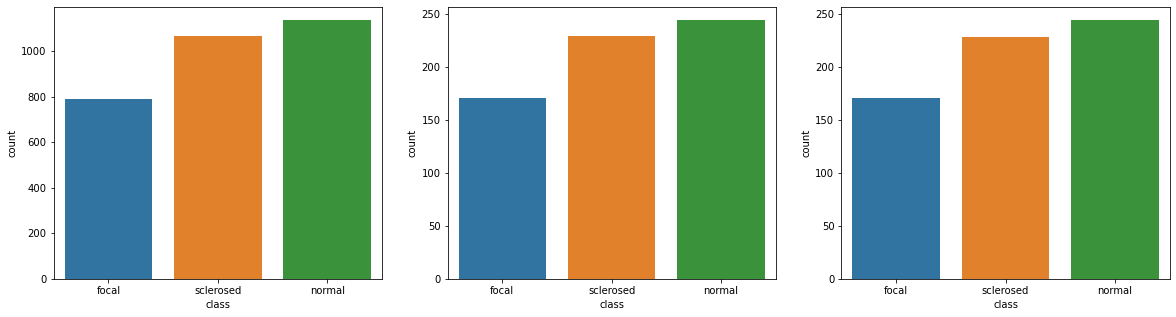

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 512

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=BUFFER_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=BUFFER_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

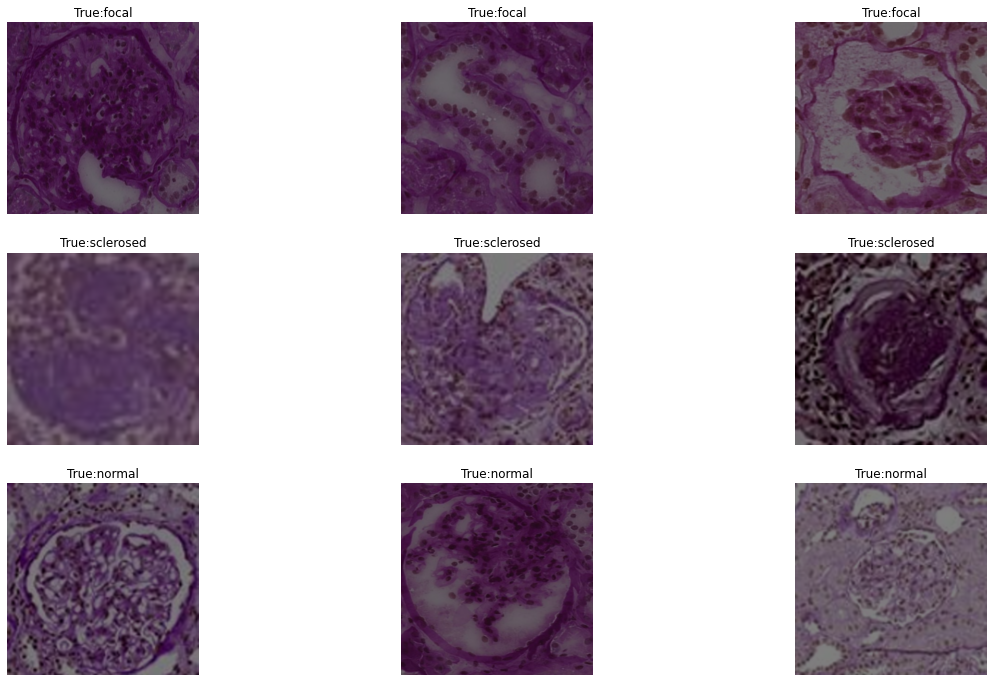

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
2993/2993 [==============================] - 1257s 420ms/step - loss: 0.8407 - acc: 0.6110 - val_loss: 0.5381 - val_acc: 0.7508
Epoch 2/5
2993/2993 [==============================] - 1378s 460ms/step - loss: 0.5741 - acc: 0.7302 - val_loss: 0.5527 - val_acc: 0.7617
Epoch 3/5
2993/2993 [==============================] - 1410s 471ms/step - loss: 0.4829 - acc: 0.7813 - val_loss: 0.4474 - val_acc: 0.8178
Epoch 4/5
2993/2993 [==============================] - 1533s 512ms/step - loss: 0.4189 - acc: 0.8270 - val_loss: 0.3993 - val_acc: 0.8271
Epoch 5/5
2993/2993 [==============================] - 1517s 507ms/step - loss: 0.3854 - acc: 0.8416 - val_loss: 0.2745 - val_acc: 0.8910


In [13]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 258s 401ms/step - loss: 0.2904 - acc: 0.9082


[0.2903943955898285, 0.9082425832748413]

In [12]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
1497/1497 [==============================] - 1217s 813ms/step - loss: 0.8241 - acc: 0.6026 - val_loss: 0.6913 - val_acc: 0.6246
Epoch 2/5
1497/1497 [==============================] - 1315s 878ms/step - loss: 0.5738 - acc: 0.7231 - val_loss: 0.4854 - val_acc: 0.7819
Epoch 3/5
1497/1497 [==============================] - 1201s 802ms/step - loss: 0.5014 - acc: 0.7735 - val_loss: 0.4855 - val_acc: 0.7804
Epoch 4/5
1497/1497 [==============================] - 1255s 838ms/step - loss: 0.4358 - acc: 0.8066 - val_loss: 0.4146 - val_acc: 0.8349
Epoch 5/5
1497/1497 [==============================] - 1455s 972ms/step - loss: 0.4161 - acc: 0.8174 - val_loss: 0.3836 - val_acc: 0.8349


In [13]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 259s 803ms/step - loss: 0.3651 - acc: 0.8569


[0.3650660216808319, 0.8569206595420837]

In [12]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
749/749 [==============================] - 1033s 1s/step - loss: 0.8620 - acc: 0.5810 - val_loss: 0.6318 - val_acc: 0.6978
Epoch 2/5
749/749 [==============================] - 1033s 1s/step - loss: 0.6175 - acc: 0.7194 - val_loss: 0.5789 - val_acc: 0.7305
Epoch 3/5
749/749 [==============================] - 1033s 1s/step - loss: 0.5297 - acc: 0.7609 - val_loss: 0.4498 - val_acc: 0.7960
Epoch 4/5
749/749 [==============================] - 1032s 1s/step - loss: 0.4565 - acc: 0.8035 - val_loss: 0.4172 - val_acc: 0.8209
Epoch 5/5
749/749 [==============================] - 1032s 1s/step - loss: 0.4317 - acc: 0.8121 - val_loss: 0.3470 - val_acc: 0.8505


In [13]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 182s 1s/step - loss: 0.3428 - acc: 0.8756


[0.34276363253593445, 0.8755832314491272]

In [14]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
375/375 [==============================] - 1010s 3s/step - loss: 0.3555 - acc: 0.8533 - val_loss: 0.3756 - val_acc: 0.8489
Epoch 2/5
375/375 [==============================] - 1003s 3s/step - loss: 0.3379 - acc: 0.8627 - val_loss: 0.3465 - val_acc: 0.8754
Epoch 3/5
375/375 [==============================] - 999s 3s/step - loss: 0.3077 - acc: 0.8844 - val_loss: 0.2898 - val_acc: 0.8956
Epoch 4/5
375/375 [==============================] - 998s 3s/step - loss: 0.3050 - acc: 0.8804 - val_loss: 0.2692 - val_acc: 0.9050
Epoch 5/5
375/375 [==============================] - 998s 3s/step - loss: 0.2915 - acc: 0.8847 - val_loss: 0.2969 - val_acc: 0.8801


In [15]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 177s 2s/step - loss: 0.3067 - acc: 0.8771


[0.30673444271087646, 0.8771384358406067]

In [16]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
188/188 [==============================] - 998s 5s/step - loss: 0.2631 - acc: 0.9054 - val_loss: 0.2592 - val_acc: 0.8988
Epoch 2/5
188/188 [==============================] - 998s 5s/step - loss: 0.2545 - acc: 0.9118 - val_loss: 0.2577 - val_acc: 0.9065
Epoch 3/5
188/188 [==============================] - 1001s 5s/step - loss: 0.2587 - acc: 0.9118 - val_loss: 0.2858 - val_acc: 0.8972
Epoch 4/5
188/188 [==============================] - 1002s 5s/step - loss: 0.2479 - acc: 0.9095 - val_loss: 0.2290 - val_acc: 0.9143
Epoch 5/5
188/188 [==============================] - 1002s 5s/step - loss: 0.2404 - acc: 0.9141 - val_loss: 0.2285 - val_acc: 0.9252


In [17]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 177s 4s/step - loss: 0.2334 - acc: 0.9253


[0.23340679705142975, 0.9253499507904053]

In [18]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 999s 11s/step - loss: 0.2206 - acc: 0.9292 - val_loss: 0.2487 - val_acc: 0.9190
Epoch 2/5
94/94 [==============================] - 1000s 11s/step - loss: 0.2201 - acc: 0.9248 - val_loss: 0.2432 - val_acc: 0.9097
Epoch 3/5
94/94 [==============================] - 1001s 11s/step - loss: 0.2162 - acc: 0.9238 - val_loss: 0.2236 - val_acc: 0.9252
Epoch 4/5
94/94 [==============================] - 1002s 11s/step - loss: 0.2220 - acc: 0.9262 - val_loss: 0.2238 - val_acc: 0.9174
Epoch 5/5
94/94 [==============================] - 1003s 11s/step - loss: 0.2150 - acc: 0.9288 - val_loss: 0.2149 - val_acc: 0.9268


In [19]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 178s 8s/step - loss: 0.2257 - acc: 0.9269


[0.22574453055858612, 0.9269051551818848]

In [20]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
47/47 [==============================] - 1005s 21s/step - loss: 0.2028 - acc: 0.9328 - val_loss: 0.2209 - val_acc: 0.9237
Epoch 2/5
47/47 [==============================] - 1001s 21s/step - loss: 0.2059 - acc: 0.9298 - val_loss: 0.2306 - val_acc: 0.9143
Epoch 3/5
47/47 [==============================] - 1001s 21s/step - loss: 0.1998 - acc: 0.9332 - val_loss: 0.2079 - val_acc: 0.9315
Epoch 4/5
47/47 [==============================] - 1001s 21s/step - loss: 0.1974 - acc: 0.9379 - val_loss: 0.2195 - val_acc: 0.9283
Epoch 5/5
47/47 [==============================] - 1002s 21s/step - loss: 0.1961 - acc: 0.9369 - val_loss: 0.2099 - val_acc: 0.9315


In [21]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 178s 16s/step - loss: 0.2241 - acc: 0.9176


[0.22408798336982727, 0.917573869228363]

In [ ]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5


In [ ]:
data_test = test(128)
model.evaluate(data_test)

In [ ]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(256)
model.evaluate(data_test)

In [ ]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(512)
model.evaluate(data_test)

In [ ]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(1024)
model.evaluate(data_test)

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(2048)
model.evaluate(data_test)